In [1]:
# %%writefile Ind_xxxxx.py

import sys
import os 
module_path = os.path.abspath(os.path.join('..')) 
if module_path not in sys.path: 
    sys.path.append(module_path)

import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import QUANTAXIS as QA

import tools.Sample_Tools as smpl
import tools.Pretreat_Tools as pretreat

import EAST.Fetcher_EM as east

from base.JuUnits import excute_for_multidates

E:\PyProjects\IndicatorLab\EAST\Crawler_Block_East.py:41: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange, tqdm


In [2]:
from tools.Cacher import (CACHE_TYPE, save_cache,load_cache_adv,load_cache)

tail = False
if tail:
    file = 'all_tail_qfq'
else:
    file = 'all_train_qfq'
    
df_all = load_cache(file,cache_type=CACHE_TYPE.STOCK).sort_index()
smpl.optimize_data_type(df_all)

data_ = df_all

year1 = '2016'
year2 = '2019'
data_ = df_all.loc[year1+'-01-03':year2+'-12-31']
codes = data_.index.get_level_values(1).unique()
dates = data_.index.get_level_values(0).unique()

In [139]:
# df_all1 = load_cache('all_train_qfq',cache_type=CACHE_TYPE.STOCK).sort_index()
# df_all2 = load_cache('all_tail_qfq',cache_type=CACHE_TYPE.STOCK).sort_index()
# df_all = pd.concat([df_all1,df_all2],axis=0).sort_index()

data_ = df_all

year1 = '2016'
year2 = '2022'
data_ = df_all.loc[year1+'-01-03':year2+'-12-31']
codes = data_.index.get_level_values(1).unique()
dates = data_.index.get_level_values(0).unique()

In [140]:
# 个股情绪

# turnover = data_['volume'] / (data_['lshares'] *100) 

# turnover_mean_month = excute_for_multidates(turnover, lambda x:x.rolling(22).mean(), level='code')
# turnover_mean_week = excute_for_multidates(turnover, lambda x:x.rolling(5).mean(), level='code')
# turnover_unknown = turnover_mean_week/turnover_mean_month

# overnight_ret = excute_for_multidates(data_, lambda x:(x['open']/x['close'].shift(1))-1, level='code')
# turnover_rate = excute_for_multidates(turnover, lambda x: x-x.shift(1), level='code')
# # 指令不平衡(净流入额/总成交额)  代理达成一致意见所需时间
# buy_sell_belance = intraday_df_tmp['bs_balance']

# ret = smpl.get_current_return(data_, 'close')
# ret_std5 = excute_for_multidates(ret, lambda x:x.rolling(5).std(), level='code')

def calc_rs(x):
    down = (x<0).sum()
    if down==0:
        rs = float(x.shape[0])
    else:
        up = (x>0).sum()
        rs = up/down
    rsi=100-100/(1+rs)
    return rsi
    
# *投资者达成一致意见所需时间 = (最高价 - 开盘价) / (收盘价 - 开盘价)
# *相对强弱指标（RSI）：计算公式：RSI=100-100/(1+RS)
   # 相对强度(RS)=一定时期收盘指数涨数的平均值/一定时期收盘指数跌数的平均值，主要和价格的收盘平均值有关，可以表现股价的运动速率。

# RSI_6 = excute_for_multidates(ret, lambda x:x.rolling(6).apply(lambda xx:calc_rs(xx)), level='code')
# RSI_12 = excute_for_multidates(ret, lambda x:x.rolling(12).apply(lambda xx:calc_rs(xx)), level='code')
# RSI_CD = RS_6-RS_12

# *随机指标（KD）
# C为当天的收；
# UP:=HHV(H,20);
# DN:=LLV(L,20);
# RSV:=(C-DN)/(UP-DN)*100;
# K:SMA(RSV,3,1);
# D:SMA(K,3,1);

def calc_kd(df):
    up = df.high.rolling(20).max()
    dn = df.low.rolling(20).min()
    c = df.close
    rsv = (c-dn)/(up-dn) * 100
    return rsv
    
KD = excute_for_multidates(data_, lambda xs:calc_kd(xs), level='code')



# volume





In [141]:
# KD[20:60]

In [142]:
# RSI_CD[24200:24260]

In [143]:
def calc_rs(x):
    down = (x<0).sum()
    if down==0:
        return float(x.shape[0])
    else:
        up = (x>0).sum()
        return up/down
    
excute_for_multidates(ret.loc[(slice(None),'000002'),], lambda x:x.rolling(12).apply(lambda xx:calc_rs(xx)), level='code')

NameError: name 'ret' is not defined

In [ ]:
def get_intraday_indicator_by_code(code,st='2016-03-01',en='2020-12-31',fr=QA.FREQUENCE.FIVE_MIN):
    def calc(varaints_daily):
        close = varaints_daily.close
        ret = (close/close.shift(1) - 1)#.dropna()
        #######指令平衡###########################
        #已实现方差 RealizedVolatility
        net_mf_amount = varaints_daily.amount[ret > 0].sum()
        neg_amount = varaints_daily.amount[ret < 0].sum()
        amount = neg_amount+net_mf_amount
        if amount == 0:
            bs_balance = 0
        else:
            bs_balance = (net_mf_amount/amount)-0.5
        ##########################################
        
        
        # print()
        return bs_balance

    stock_df = smpl.get_data(code, start=st, end=en, gap=None, freq=fr)
    if stock_df is None:
        return None
    stock_df = stock_df.data
    columns = ['close','volume','amount']
    var = stock_df[columns]
    var_unindex = var.reset_index()

    res = var_unindex[columns].groupby(var_unindex.datetime.dt.to_period("D"),group_keys=False).apply(lambda x: calc(x))
    res_df = pd.DataFrame(res.to_list(),
                          index=pd.MultiIndex.from_arrays([res.index.to_timestamp(),[code]*len(res.index)]),
                          columns=['bs_balance'])
    
    return res_df

intraday_df_tmp = pd.DataFrame()
for code in ['002415']:
    res = get_intraday_indicator_by_code(code,dates.min().strftime('%Y-%m-%d'),dates.max().strftime('%Y-%m-%d'))
    if res is None:
        continue
    intraday_df_tmp = pd.concat([intraday_df_tmp,res],axis=0)

In [ ]:
# a = smpl.get_index_data(['880810','880811'], start=dates.min(), end=dates.max(), gap=None).data
# a = turnover_unknown.loc[(slice(None),'000001')]
a = KD.loc[(slice(None),'000002'),]
d = a.index.get_level_values(0).unique()
# bench = smpl.get_benchmark(name='沪深300', start=d.min(), end=d.max()).data
bench = data_.loc[(slice(None),'000002'),]

In [ ]:
fig = plt.figure(figsize=(1420/72,320/72))
# a['close'].groupby(level=1).apply(lambda x:x.plot())
a.plot()
# ax2 = plt.gca()
# ax2.plot(range(bench.shape[0]),(0.5*a['close'].loc[(slice(None),'880876')].values+0.5*a['close'].loc[(slice(None),'880877')]).values,linewidth=2,color="red")



ax3 = plt.gca().twinx()
ax3.plot(range(bench.shape[0]),bench['close'].values,linestyle=":", linewidth=2,color="black",label='bm')
# ax3.plot(bench.index.get_level_values(0).values,bench['close'].values,linestyle=":", linewidth=2,color="black",label='bm')


In [ ]:
data_

In [ ]:
a.corr(bench['close'])

In [ ]:
(a['close'].loc[(slice(None),'880811')]).corr(bench['close'])

In [ ]:
(a['close'].loc[(slice(None),'880008')]).corr(a['close'].loc[(slice(None),'880018')])

In [ ]:
a

In [ ]:
a['close'].loc[(slice(None),'880780')]

In [ ]:
# 市场情绪
# n=east.fetch_north_deal_day(direct='north_', start=dates.min(), end=dates.max()).data
# s=east.fetch_north_deal_day(direct='south_', start=dates.min(), end=dates.max()).data
#~ 880780 融资增加 2019开始
#~ 880792 基金增仓 2020
#~ 880793 基金减仓 2020
#~ 880751 昨日跌停# 880863  昨日涨停 # 880876 户数增加 # 880877 户数减少
#~ 880752 昨曾跌停# 880874  昨曾涨停
#~ 880008 全Ａ等权
#~ 880018 主板等权


# 880990 TDX 金融 
# 880005 涨跌家数 收=涨数，开=跌数
# 880006 停板家数 收=涨停数，开=跌停数，高=最大涨停数

# 4.简易市场情绪
# 每日涨停/跌停数

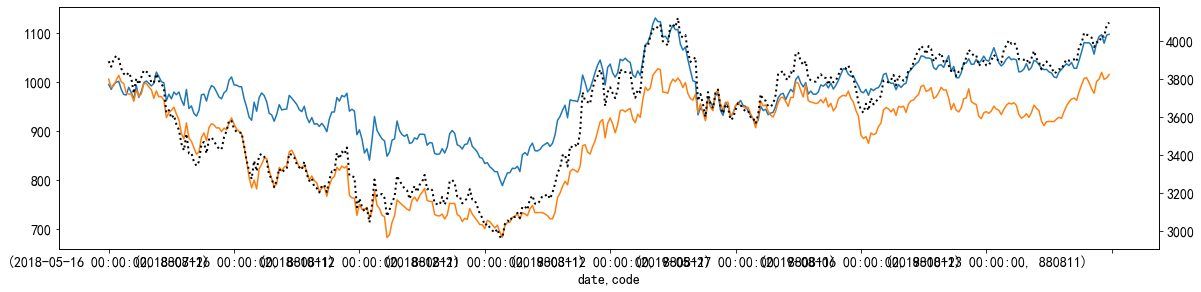

In [161]:
a = smpl.get_index_data(['880810','880811'], start=dates.min(), end=dates.max(), gap=None).data
d = a.index.get_level_values(0).unique()
bench = smpl.get_benchmark(name='沪深300', start=d.min(), end=d.max()).data

fig = plt.figure(figsize=(1420/72,320/72))
a['close'].groupby(level=1).apply(lambda x:x.plot())


ax3 = plt.gca().twinx()
ax3.plot(range(bench.shape[0]),bench['close'].values,linestyle=":", linewidth=2,color="black",label='bm')
# ax3.plot(bench.index.get_level_values(0).values,bench['close'].values,linestyle=":", linewidth=2,color="black",label='bm')


In [68]:
from pmdarima import auto_arima
import pmdarima

In [165]:
# c = data_.loc[(slice(None),['000001','000002','601919','002415']),]
c = data_.loc[(slice(None),['002603']),]
c_ret = smpl.get_current_return(c,'close').dropna()
# c_ret_x = c_ret.shift(1).dropna().values
# c_ret_y = c_ret[1:].values
# c_ret_x = c_ret.shift(1).dropna().values.reshape(-1,1)
# c_ret_y = c_ret[1:].values.reshape(-1,1)



In [171]:
model = auto_arima(c_ret,seasonal=False,trace=True,d=1)
model.summary()


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.96 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4317.419, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4593.675, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4319.398, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-4733.309, Time=0.21 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-4794.397, Time=0.44 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-4810.788, Time=0.71 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-4834.484, Time=0.80 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-4945.799, Time=1.10 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-4964.323, Time=1.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-4959.831, Time=0.84 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-4949.133, Time=1.21 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.20 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   :

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  974
Model:               SARIMAX(4, 1, 1)   Log Likelihood                2489.162
Date:                Mon, 23 Oct 2023   AIC                          -4964.323
Time:                        00:08:25   BIC                          -4930.161
Sample:                             0   HQIC                         -4951.322
                                - 974                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    3.53e-06   1.94e-05      0.182      0.856   -3.46e-05    4.16e-05
ar.L1         -0.0595      0.031     -1.895      0.058      -0.121       0.002
ar.L2          0.0437      0.030      1.450      0.147      -0.015       0.103
ar.L3         -0.0161      0.030     -0.537      0.591      -0.075       0.043
ar.L4          0.0166      0.031      0.539      0.590      -0.044       0.077
ma.L1         -0.9713      0.012    -83.202      0.000      -0.994      -0.948
sigma2         0.0004   1.07e-05     32.783      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.40   Jarque-Bera (JB):               267.11
Prob(Q):                              0.53   Prob(JB):                         0.00
Heteroskedasticity (H):               0.92   Skew:                            -0.05
Prob(H) (two-sided):                  0.47   Kurtosis:                         5.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [166]:
model = pmdarima.arima.ARIMA(order=(3,1,3))
model.fit(c_ret)
model.summary()


D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  974
Model:               SARIMAX(3, 1, 3)   Log Likelihood                2497.748
Date:                Mon, 23 Oct 2023   AIC                          -4979.495
Time:                        00:07:35   BIC                          -4940.452
Sample:                             0   HQIC                         -4964.636
                                - 974                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -2.069e-06   1.31e-05     -0.158      0.874   -2.77e-05    2.36e-05
ar.L1         -1.1894      0.258     -4.614      0.000      -1.695      -0.684
ar.L2         -0.7828      0.239     -3.282      0.001      -1.250      -0.315
ar.L3         -0.0282      0.033     -0.845      0.398      -0.094       0.037
ma.L1          0.1980      0.259      0.766      0.444      -0.309       0.705
ma.L2         -0.4201      0.205     -2.051      0.040      -0.821      -0.019
ma.L3         -0.7611      0.250     -3.045      0.002      -1.251      -0.271
sigma2         0.0003   1.03e-05     33.323      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.65   Jarque-Bera (JB):               296.77
Prob(Q):                              0.42   Prob(JB):                         0.00
Heteroskedasticity (H):               0.91   Skew:                            -0.05
Prob(H) (two-sided):                  0.41   Kurtosis:                         5.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [168]:
c_ret

date        code  
2016-01-05  002603   -0.018902
2016-01-06  002603    0.006836
2016-01-07  002603   -0.087654
2016-01-08  002603    0.023681
2016-01-11  002603   -0.079313
                        ...   
2019-12-25  002603    0.015138
2019-12-26  002603   -0.003509
2019-12-27  002603   -0.006162
2019-12-30  002603    0.000886
2019-12-31  002603    0.100000
Name: ret, Length: 974, dtype: float32

In [167]:
model.predict_in_sample(X=c_ret)
# model.predict_in_sample(start=1,end=len(c_ret)-1)

date        code  
2016-01-05  002603   -6.896848e-07
2016-01-06  002603   -1.890311e-02
2016-01-07  002603   -5.738839e-03
2016-01-08  002603   -3.456009e-02
2016-01-11  002603   -1.756165e-02
                          ...     
2019-12-25  002603    5.600892e-04
2019-12-26  002603   -3.452899e-04
2019-12-27  002603   -1.176290e-03
2019-12-30  002603    5.602169e-04
2019-12-31  002603   -3.299362e-04
Name: predicted_mean, Length: 974, dtype: float64

<AxesSubplot:xlabel='date,code'>

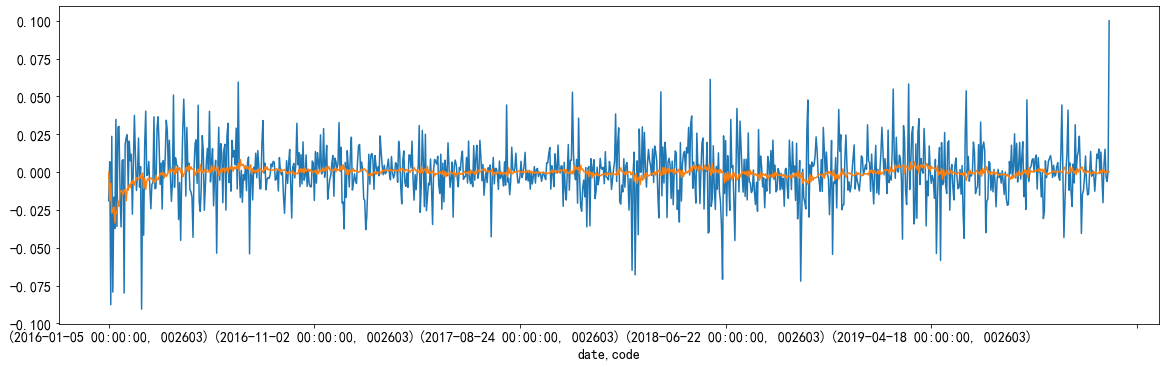

In [172]:
fig = plt.figure(figsize=(1420/72,420/72))
c_ret.plot()
model.predict_in_sample(X=c_ret).plot()

<AxesSubplot:xlabel='date,code'>

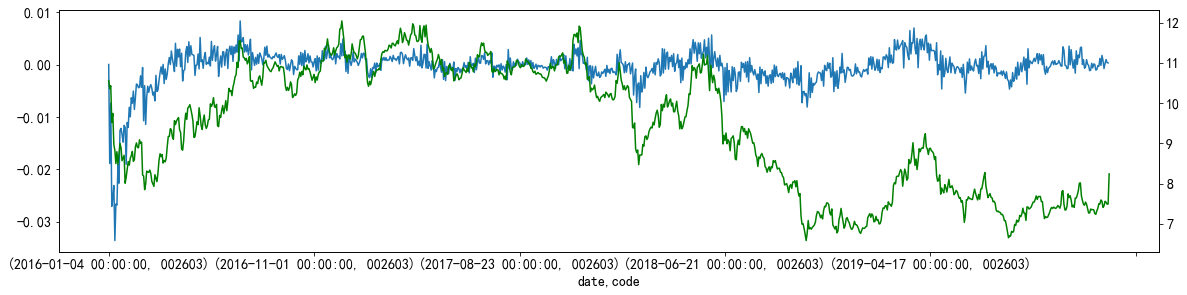

In [173]:
fig = plt.figure(figsize=(1420/72,320/72))
model.predict_in_sample(X=c_ret).plot()
plt.gca().twinx()
c.close.plot(color='green')